# DINTA: Tutorial sobre Deep Q-Network

Este tutorial está basado en el material creado por Evan Hennis (https://github.com/ehennis/ReinforcementLearning).

El objetivo es entender en detalle cómo funciona un algoritmo de Deep Reinforcement Learning. En particular, estudiaremos Deep Q-Network (DQN) y analizaremos su comportamiento en un problema sencillo.

## Aprendizaje Reforzado (resumen)

Recordemos que los agentes de aprendizaje reforzado aprenden a resolver problemas mediante ensayo y error.


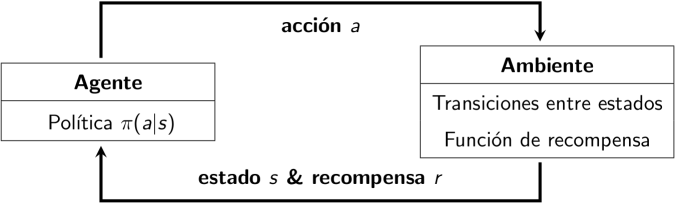

Dado el estado actual del ambiente $s$, el agente decide qué acción $a$ ejecutar según su política $\pi(a|s)$. Por ejemplo, si el estado actual muestra que el agente está abajo de la galleta entonce $\pi(a|s)$ debería indicarle al agente que se mueva hacia arriba. Luego de ejecutar la acción, el ambiente retorna el siguiente estado $s'$ y recompensa $r$.

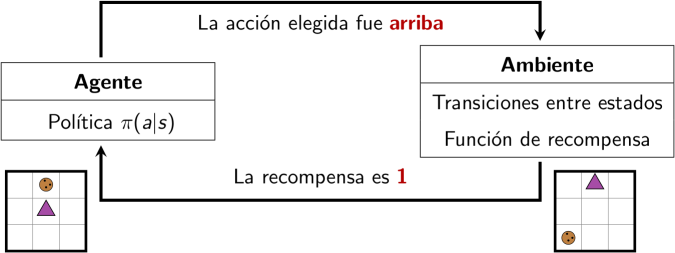

El objetivo del agente es obtener la mayor cantidad de recompensas posible del ambiente. Para ello ajusta su polı́tica $\pi(a|s)$ con el objetivo de obtener más recompensa.

Formalmente, el objetivo del agente es encontrar una política óptima $\pi^*$. Esto es, una política que en *promedio* obtenga la mayor suma de recompensas de parte del ambiente.

$$
\pi^* = \text{argmax}_{\pi \in \Pi}\ \mathbb{E}_{\pi}\left[\sum_{t=0}^{\infty}\gamma^tR_{t+1}\right]
$$

### Métodos basados en Q-learning

Para encontrar $\pi^*$, los métodos basados en Q-learning usan la experiencia del agente para estimar los Q-values óptimos. Estos Q-values se definen de la siguiente manera:

$$
q_*(s,a) = \max_{\pi \in \Pi}\ \mathbb{E}_{\pi}\left[\sum_{t=0}^{\infty}\gamma^tR_{t+1}\middle| S_0 = s, A_0 = a\right]
$$

Los Q-values óptimos $q_*(s,a)$ representan la recompensa que una política obtendría si ejecutara la acción $a$ en el estado $s$ y luego siguiera ejecutando acciones de forma óptima. Es decir, $q_*(s,a)$ nos indica cuánta recompensa se puede recibir (en el mejor caso) si ejecutamos la acción $a$ en el estado $s$. Por lo mismo, si conocemos $q_*(s,a)$ podemos extraer una política óptima mediante elegir siempre la acción con mayor Q-value:

$$
\pi^*(a|s) = \text{argmax}_{a \in A}\ q_*(s,a)
$$

Cuando el ambiente es modelado como un *MDP* los Q-values óptimos cumplen con la siguiente propiedad (para todo $s \in S$ y $a \in A$):

$$
q_*(s,a) = \sum_{s'\in S} p(s'|s,a) \left[ r(s,a,s') + \gamma \max_{a' \in A} q_*(s',a') \right]
$$

Los métodos del tipo Q-learning usan la *experiencia* del agente para estimar $q_*(s,a)$. Una experiencia es una tupla $(s,a,r,s')$ donde $s$ es el estado en que se encontraba el agente cuando ejecutó la acción $a$. Como resultado, el agente terminó en el estado $s'$ y recibió una recompensa $r$. Dada cualquier experiencia, un agente puede mejorar su estimación $Q_t(s,a)$ de $q_*(s,a)$ usando la siguiente regla de aprendizaje:

$$
Q_{t+1}(s,a) = Q_t(s,a) + \alpha\left[ r + \gamma \max_{a'} Q_t(s',a') - Q_t(s,a)\right]
$$

Donde $\alpha \in (0,1]$ es el *learning rate*. Intuitivamente, usar esta regla de aprendizaje múltiples veces conseguirá que $Q_t(s,a) = q_*(s,a)$ cuando $t \rightarrow ∞$ (independiente de la asignacion inicial de $Q_0(s,a)$).



## OpenAI Gym

**Documentación**: https://www.gymlibrary.ml/

Con el boom causado por DQN a finales del 2013, investigadores de todo el mundo comenzaron a crear sus propios ambientes y agentes de aprendizaje reforzado. Esto produjo el problema de que cada uno seguía sus propias convenciones y se hacía difícil probar distintos agentes para resolver un problema nuevo (pues sus códigos eran incompatibles).

A finales del 2015, OpenAI propuso una elegante solución a este problema: *GYM*. GYM es una librería que permite definir *ambientes* para agentes de aprendizaje reforzado de manera estándar. Hoy en día prácticamente todos los agentes de aprendizaje reforzado usan GYM. Es decir, si codificas tu dominio en GYM serás capaz de usar el código de casi cualquier agente para resolver tu problema.

Además GYM ya cuenta con una gran variedad de ambientes disponibles para testear agentes.

In [1]:
from IPython.display import HTML
HTML('<video width=600 controls autoplay><source src="{}" type="video/mp4"></video>'.format('https://cdn.openai.com/research-covers/retro-heavy/heavy_tile.mp4'))

Partamos por importar GYM y algunas librerías asociadas.

In [11]:
#Imports
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow import keras
import random
tf.keras.utils.disable_interactive_logging()

En este tutorial usaremos el ambiente conocido como *Cart Pole*. Cart pole es un ámbiente clásico, usado durante años para testear agentes de aprendizaje reforzado. La tarea es simple. Un bastón es atornillado a un auto que se puede mover a la izquierda o a la derecha. El objetivo es controlar el auto tal que el bastón no se caiga.

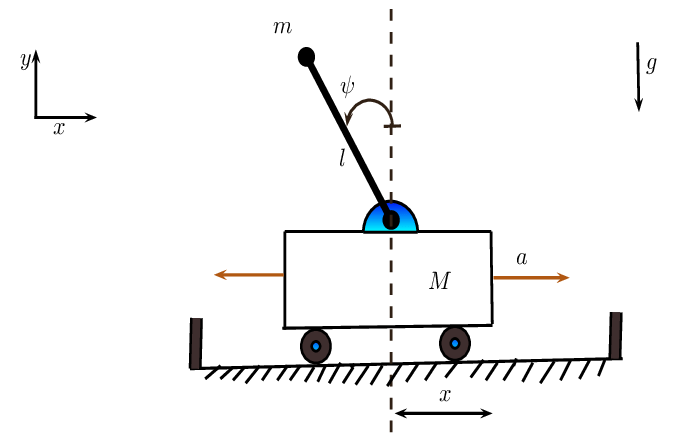

Este ambiente incluye dos acciones (acelerar a la izquierda o a la derecha) y su estado incluye 4 valores:

*   La posición del auto.
*   La velocidad del auto.
*   El ángulo del bastón.
*   La velocidad angular del bastón.

La recompensa es +1 por cada momento que el bastón se encuentra equilibrado. El episodio termina cuando el bastón se cae.

Una versión de este dominio ya se encuentra implementada en GYM.



In [12]:
HTML('<video width=600 controls autoplay><source src="{}" type="video/mp4"></video>'.format('https://thumbs.gfycat.com/GreedyJampackedBlackfish-mobile.mp4'))

Para usarla basta con ejecutar el siguiente comando:

```
gym.make('CartPole-v1')
```

Además, podemos ver qué tal le va a un agente que selecciona acciones en forma 100% aleatoria. El objetivo de este ejemplo es familiarizarse con la interfaz definida por GYM.

In [13]:
env = gym.make('CartPole-v1', new_step_api=True)  # Creamos el ambiente
observation = env.reset() # Reiniciamos el ambiente
total_reward = 0
num_episode = 1
while num_episode <= 10:
   action = random.choice([0,1])       # Elegimos acción aleatoria
   observation, reward, done, truncated, info = env.step(action)  # Ejecutamos la acción
   total_reward += reward
   if done:  # Si el episodio termina volvemos a inicial el ambiente
      observation = env.reset()
      print(f"Episode {num_episode}. Total reward: {total_reward}")
      total_reward = 0
      num_episode += 1
env.close()  # Cerramos el ambiente

Episode 1. Total reward: 17.0
Episode 2. Total reward: 32.0
Episode 3. Total reward: 23.0
Episode 4. Total reward: 23.0
Episode 5. Total reward: 14.0
Episode 6. Total reward: 21.0
Episode 7. Total reward: 28.0
Episode 8. Total reward: 14.0
Episode 9. Total reward: 15.0
Episode 10. Total reward: 48.0


**Pregunta**: ¿Por qué es importante que el estado incluya información sobre la velocidad del auto y del bastón? ¿acaso no es suficiente con conocer sus posiciones actuales?

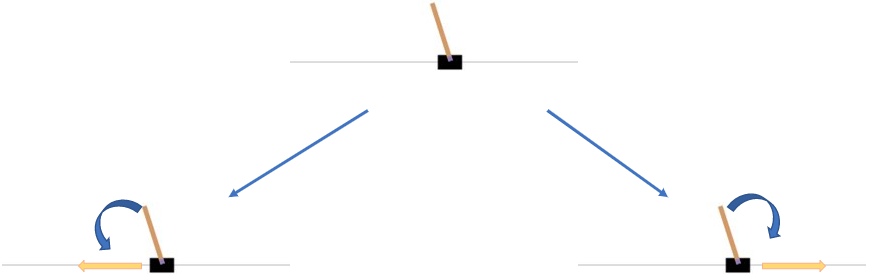

## Deep Q-Network (DQN)

La idea general detrás de DQN se resume con el siguiente diagrama:

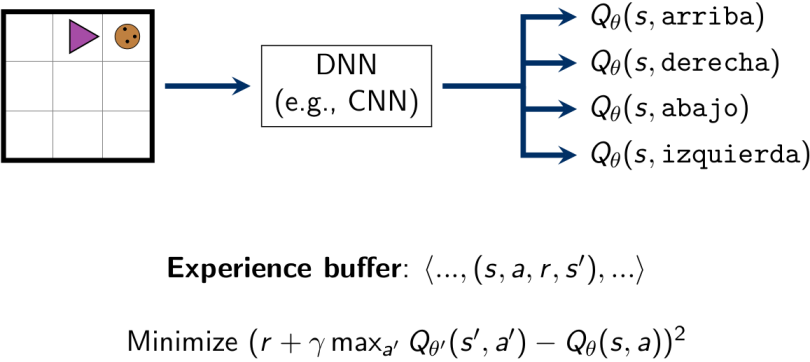

DQN usa una red neuronal que recibe el estado actual (que puede ser una imagen) y su salida son las estimaciones de de los Q-values $Q_{\theta}(s,a)$ por cada acción posible $a \in A$.

Por ejemplo, la entrada de una red para resolver *cart pole* será un vector con 4 *features* y su salida serán 2 valores (que representan los Q-values de moverse a la izquierda y a la derecha).

Para entrenar la red neuronal es necesario crear un set de entrenamiento. DQN crea este set de entrenamiento de manera incremental. A medida que el agente interactúa con el ambiente ve recolectando experiencias $(s,a,r,s')$ y las guardada en un *experience replay buffer*. En DQN, este buffer pasa a ser el set de entrenamiento de la red neuronal.

La red neuronal se entrena luego de cada acción que el agente ejecuta en el ambiente. En concreto, un mini-batch de experiencias son muestradas del buffer y se usan para entrenar la red neuronal mediante minimizar la siguiente función de pérdida:

$$
\mathcal{L} = \sum_{s,a,r,s'}(r + \gamma \max_{a'} Q_{\theta'}(s',a') - Q_{\theta})^2
$$

En un alto nivel, DQN funciona más o menos así (este código es solo para propósitos ilustrativos):

```
# Hyperparámetros
lr = 0.001
epsilon = 0.1
batch_size = 32
num_steps = 10**6

# Creamos la red, el ambiente y comenzamos el entrenamiento
DQN = initialize_network()
buffer = []
env = create_environment()
A = env.action_space()
s = env.reset()
for step in range(num_steps):
   # Seleccionando la acción a ejecutar
   if random.random() < epsilon:
      a = random.choice(A)
   else:
      a = DQN.get_action_with_the_largest_Qvalue(s)
   
   # Ejecutar acción
   sn, r, done, _ = env.step(a)
   
   # Guardamos la experiencia en el buffer
   experience = (s,a,r,sn,done)
   buffer.append(experience)

   # Si hay suficiente experiencia guardada actualizamos la red
   if len(buffer) > batch_size:
      mini_batch = buffer.sample(batch_size)
      DQN.update_weights(mini_batch, lr)

   # Se reinicia el dominio cuando done es verdadero
   if done:
      sn = env.reset()

   # Continuamos desde el siguiente estado
   s = sn

env.close()
```

  



Ahora bien, el código real de DQN tiene varios detalles extra. Pero la idea general es la misma. Primero definamos algunos hyperparámetros:

In [25]:
# Hyperparámetros
def discount_rate():
    return 0.95

def learning_rate():
    return 0.001

def batch_size():
    return 24

Ahora definamos la red de DQN con tres métodos principales:

1.   **get_action_epsilon_greedy(self, state):** Retorna la acción elegida por DQN para ser ejecutada en **state**. Notar que con probabilidad $\epsilon$ se retorna una acción aleatoria.
2.   **store(self, state, action, reward, nstate, done):** Guarda esta experiencia en el buffer para entrenar la red.
3.   **learn(self, batch_size):** Actualiza los pesos de la red usando un minibatch de tamaño **batch_size**.



In [26]:
class DeepQNetwork():
    def __init__(self, states, actions, alpha, gamma, epsilon,epsilon_min, epsilon_decay):
        self.nS = states
        self.nA = actions
        self.memory = deque([], maxlen=2500) # experience replay buffer
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # factor de descuento
        #Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self.build_model()
        self.loss = []

    def build_model(self):
        # Para este problema basta con usar una red pequeña (MLP con dos hidden layers de 24 neuronas)
        model = keras.Sequential()
        model.add(keras.layers.Dense(24, input_dim=self.nS, activation='relu'))
        model.add(keras.layers.Dense(24, activation='relu'))
        model.add(keras.layers.Dense(self.nA, activation='linear'))
        model.compile(loss='mean_squared_error',
                      optimizer=keras.optimizers.Adam(learning_rate=self.alpha))
        return model

    def get_action_epsilon_greedy(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.nA)    # Explorar con una acción random
        action_vals = self.model.predict(state) # Explotar usando la mejor acción según la red
        return np.argmax(action_vals[0])

    def get_best_action(self, state):
        # Retorna la acción con mayor Q-value
        action_vals = self.model.predict(state)
        return np.argmax(action_vals[0])

    def store(self, state, action, reward, nstate, done):
        # Guarda esta experiencia en el experience replay buffer
        self.memory.append( (state, action, reward, nstate, done) )

    def learn(self, batch_size):
        # Obtener un mini batch desde el buffer
        minibatch = random.sample( self.memory, batch_size)

        # Por cada experiencia calculamos "r + gamma*max_{a'} Q(s',a')"
        # y usamos ese valor como el target para Q(s,a)
        x = []
        y = []
        np_array = np.array(minibatch, dtype=object)
        st = np.zeros((0,self.nS))
        nst = np.zeros((0,self.nS))
        for i in range(len(np_array)):
            st = np.append( st, np_array[i,0], axis=0)
            nst = np.append( nst, np_array[i,3], axis=0)
        st_predict = self.model.predict(st)
        nst_predict = self.model.predict(nst)
        index = 0
        for state, action, reward, nstate, done in minibatch:
            x.append(state)
            # obtenemos los Q-values para el siguiente estado
            nst_action_predict_model = nst_predict[index]
            if done == True: # Estado terminal
                target = reward
            else:            # Estado no terminal
                target = reward + self.gamma * np.amax(nst_action_predict_model)
            target_f = st_predict[index]
            target_f[action] = target
            y.append(target_f)
            index += 1
        x_reshape = np.array(x).reshape(batch_size,self.nS)
        y_reshape = np.array(y)
        epoch_count = 1 # Entrenamos por una época
        hist = self.model.fit(x_reshape, y_reshape, epochs=epoch_count, verbose=0)
        # Guardamos la loss
        for i in range(epoch_count):
            self.loss.append( hist.history['loss'][i] )
        # Hacemos decrecer el valor de epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

Luego el loop de entrenamiento sería así (ejecutar este código demora alrededor de 30 minutos):

In [27]:
# Variables globales
MAX_EPISODES = 500
TRAIN_END = 0

# Creamos el ambiente
envCartPole = gym.make('CartPole-v1', new_step_api=True)
envCartPole.seed(seed=50)

# Creamos el agente de DQN
nS = envCartPole.observation_space.shape[0]
nA = envCartPole.action_space.n #Actions
dqn = DeepQNetwork(nS, nA, learning_rate(), discount_rate(), 1, 0.001, 0.995 )

batch_size = batch_size()

# Fase de entrenamiento
rewards = []
epsilons = []
for e in range(MAX_EPISODES):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0
    for time in range(210): # Ponemos un límite de tiempo a cada episodio de 210
        # Seleccionamos y ejecutamos la acción
        action = dqn.get_action_epsilon_greedy(state)
        nstate, reward, done, _, _ = envCartPole.step(action)
        nstate = np.reshape(nstate, [1, nS])
        tot_rewards += reward

        # Guardamos la experiencia en el replay buffer
        dqn.store(state, action, reward, nstate, done)

        # Nos movemos al siguiente estado
        state = nstate
        if done or time == 209:
            rewards.append(tot_rewards)
            epsilons.append(dqn.epsilon)
            print(f"episode: {e}/{MAX_EPISODES}, score: {tot_rewards}, e: {dqn.epsilon}")
            break

        # Actualizamos los pesos de la red usando un batch de datos
        if len(dqn.memory) > batch_size:
            dqn.learn(batch_size)

    # Vamos a parar el entrenamiento cuando el agente obtenga más de 195 de
    # recompensa por 5 episodios seguidos
    if len(rewards) > 5 and np.average(rewards[-5:]) > 195:
        TRAIN_END = e
        break


episode: 0/500, score: 40.0, e: 0.9275689688183278
episode: 1/500, score: 12.0, e: 0.8778091417340573
episode: 2/500, score: 11.0, e: 0.8348931673187264
episode: 3/500, score: 19.0, e: 0.7628626641409962
episode: 4/500, score: 40.0, e: 0.6274028820538087
episode: 5/500, score: 16.0, e: 0.5819594443402982
episode: 6/500, score: 17.0, e: 0.5371084840724134
episode: 7/500, score: 14.0, e: 0.5032248303978422
episode: 8/500, score: 12.0, e: 0.47622912292284103
episode: 9/500, score: 11.0, e: 0.4529463432347434
episode: 10/500, score: 15.0, e: 0.4222502236424958
episode: 11/500, score: 10.0, e: 0.4036245882390106
episode: 12/500, score: 15.0, e: 0.37627099809304654
episode: 13/500, score: 10.0, e: 0.3596735257153405
episode: 14/500, score: 11.0, e: 0.3420891339682016
episode: 15/500, score: 11.0, e: 0.3253644408394192
episode: 16/500, score: 9.0, e: 0.3125753549412418
episode: 17/500, score: 15.0, e: 0.2913921604631864
episode: 18/500, score: 10.0, e: 0.27853872940185365
episode: 19/500, sco

Luego podemos testear la política que aprendió el agente. En este caso, el agente siempre selecciona la acción con mayor Q-value (es decir, no explora). Además, no sigue entrenando la red neuronal. Simplemente ejecuta la política aprendida.

In [28]:
# Este código testea la política aprendida por el agente usando epsilon = 0
TEST_Episodes = 100
for e_test in range(TEST_Episodes):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0
    for t_test in range(210):
        action = dqn.get_best_action(state)
        nstate, reward, done, _, _ = envCartPole.step(action)
        nstate = np.reshape( nstate, [1, nS])
        tot_rewards += reward
        state = nstate
        if done or t_test == 209:
            rewards.append(tot_rewards)
            epsilons.append(0)
            print(f"episode: {e_test}/{TEST_Episodes}, score: {tot_rewards}")
            break;

episode: 0/100, score: 210.0
episode: 1/100, score: 210.0
episode: 2/100, score: 210.0
episode: 3/100, score: 210.0
episode: 4/100, score: 210.0
episode: 5/100, score: 210.0
episode: 6/100, score: 210.0
episode: 7/100, score: 210.0
episode: 8/100, score: 210.0
episode: 9/100, score: 210.0
episode: 10/100, score: 210.0
episode: 11/100, score: 210.0
episode: 12/100, score: 210.0
episode: 13/100, score: 210.0
episode: 14/100, score: 210.0
episode: 15/100, score: 210.0
episode: 16/100, score: 210.0
episode: 17/100, score: 210.0
episode: 18/100, score: 210.0
episode: 19/100, score: 210.0
episode: 20/100, score: 210.0
episode: 21/100, score: 210.0
episode: 22/100, score: 210.0
episode: 23/100, score: 210.0
episode: 24/100, score: 210.0
episode: 25/100, score: 210.0
episode: 26/100, score: 210.0
episode: 27/100, score: 210.0
episode: 28/100, score: 210.0
episode: 29/100, score: 210.0
episode: 30/100, score: 210.0
episode: 31/100, score: 210.0
episode: 32/100, score: 210.0
episode: 33/100, sco

Finalmente, podemos graficar el rendimiento del agente a medida que pasa el tiempo. Este gráfico nos muestra cuánta experiencia necesitó DQN para resolver este problema.

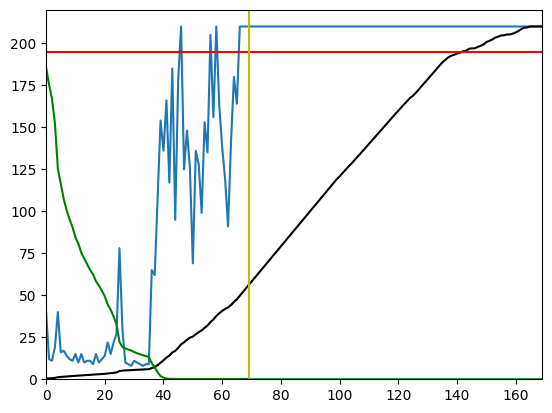

In [29]:
rolling_average = np.convolve(rewards, np.ones(100)/100)

plt.plot(rewards)
plt.plot(rolling_average, color='black')
plt.axhline(y=195, color='r', linestyle='-')
eps_graph = [200*x for x in epsilons]
plt.plot(eps_graph, color='g', linestyle='-')
plt.axvline(x=TRAIN_END, color='y', linestyle='-')
plt.xlim( (0,TRAIN_END+TEST_Episodes) )
plt.ylim( (0,220) )
plt.show()

envCartPole.close()

## Tarea

Responder a las siguientes preguntas. Por favor recuerda poner tu nombre al jupyter notebook al entregarlo.

**1)** DQN entrena una red neuronal para resolver problemas de decisión. Sin embargo, entrenar una red neuronal requiere de un set de entrenamiento. ¿De dónde salen los datos que utiliza DQN para entrenar su red?

**Respuesta**:

**2)** En el dominio *cart pole*, ¿por qué es importante que el estado incluya información sobre las velocidaded del auto y del bastón?

**Respuesta**:

## Conclusión

El objetivo de este tutorial fue introducir los conceptos principales detrás del aprendizaje reforzado y DQN. La implementación descrita de DQN está lejos de ser una implementación eficiente. Su propósito es para fines educativos.

Para encontrar implementaciones eficientes de DQN (y otros algoritmos de aprendizaje reforzado) recomendamos revisar los siguientes repositorios:


*   **OpenAI baselines**: https://github.com/openai/baselines
*   **PyTorch Actor-Critic**: https://github.com/lcswillems/torch-ac
*   **Deep Reinforcement Learning in PyTorch**: https://github.com/astooke/rlpyt


**Reference**  
Mnih, V., Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G., ... & Petersen, S. (2015). *Human-level control through deep reinforcement learning*. Nature, 518(7540), 529